In [ ]:
# main.py
from data.loader import DataLoader
from data.preprocessing import normalize_images, add_channel_dimension, one_hot_encode, filter_and_reindex_with_mapping
from eda.visualizations import plot_pixel_distribution, display_one_random_image_per_class, plot_class_distribution, plot_average_images, plot_dimensionality_reduction
from models.cnn import build_cnn_model, train_cnn_model
from models.evaluation import  plot_training_history, evaluate_model, test_single_sample, evaluate_single_image
from utils import set_japanese_font, display_class_samples

from sklearn.model_selection import train_test_split
# import numpy as np

# import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/Users/sid/Desktop/ETL5/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CONSTS
num_records = 46 * 208 * 2
epochs = 50

katakana_chars_modern = [
    "ア", "イ", "ウ", "エ", "オ",  # A-row
    "カ", "キ", "ク", "ケ", "コ",  # K-row
    "サ", "シ", "ス", "セ", "ソ",  # S-row
    "タ", "チ", "ツ", "テ", "ト",  # T-row
    "ナ", "ニ", "ヌ", "ネ", "ノ",  # N-row
    "ハ", "ヒ", "フ", "ヘ", "ホ",  # H-row
    "マ", "ミ", "ム", "メ", "モ",  # M-row
    "ヤ",       "ユ",      "ヨ",   # Y-row
    "ラ", "リ", "ル", "レ", "ロ",  # R-row
    "ワ",                "ヲ",     # W-row
    "ン"                         # N
]

katakana_chars = [
    # A-row
    "ア", "イ", "ウ", "エ", "オ",
    # K-row
    "カ", "キ", "ク", "ケ", "コ",
    # S-row
    "サ", "シ", "ス", "セ", "ソ",
    # T-row
    "タ", "チ", "ツ", "テ", "ト",
    # N-row
    "ナ", "ニ", "ヌ", "ネ", "ノ",
    # H-row
    "ハ", "ヒ", "フ", "ヘ", "ホ",
    # M-row
    "マ", "ミ", "ム", "メ", "モ",
    # Y-row
    "ヤ", "イェ", "ユ", "イォ", "ヨ", # obsolete (イェ, イォ)
    # R-row
    "ラ", "リ", "ル", "レ", "ロ",
    # W-row (now complete!) # obsolete (ヰ, ヱ, ヮ)
    "ワ", "ヰ", "ヱ", "ヲ", "ヮ",
    # N
    "ン",
    # Historical/Obsolete
    # "ヸ", "ヹ", "ヺ", "ヿ"
]


invalid_label_indices = [36, 38, 46, 47, 48]

for label in invalid_label_indices:
    print(katakana_chars[label])


イェ
イォ
ヰ
ヱ
ヲ


In [ ]:
class Main:
    def __init__(self, file_path = 'ETL5C'):
        self.file_path = file_path
        self.data = None
        self.labels = None
        self.mapped = None
        self.model = None 
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.history = None

    def load_data(self):
        loader = DataLoader(self.file_path)
        images, labels = loader.load(num_records=num_records)
        self.data = images
        self.labels = labels

    def preprocess(self):
        images = normalize_images(self.data)
        images = add_channel_dimension(images)
        self.data, int_labels, self.mapped, self.mapping = filter_and_reindex_with_mapping(
            images, invalid_label_indices)
        self.labels = one_hot_encode(int_labels, num_classes=len(self.mapping))


    def create_class_names(self):
        reverse_mapping = {new_idx: orig_idx for orig_idx, new_idx in self.mapping.items()}
        self.class_names = []
        for i in range(len(self.mapping)):
            orig_idx = reverse_mapping[i]
            if orig_idx < len(katakana_chars_modern):
                self.class_names.append(katakana_chars_modern[orig_idx])
            else:
                self.class_names.append(f"Unknown-{orig_idx}")
        print(f"Created class names list with {len(self.class_names)} classes")

    def eda(self):
        display_one_random_image_per_class(self.mapped, katakana_chars_modern)
        plot_average_images(self.labels, self.data, katakana_chars_modern)
        plot_pixel_distribution(self.data)
        plot_class_distribution(self.labels)
        plot_dimensionality_reduction(self.data, self.labels)


    def build_model(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.labels, test_size=0.2, random_state=42)
        self.model = build_cnn_model(input_shape=self.X_train.shape[1:], num_classes=self.y_train.shape[1], learning_rate=0.001)
        self.model.summary()

        self.history = train_cnn_model(self.model, self.X_train, self.y_train, self.X_test, self.y_test, epochs=epochs, batch_size=32)

        self.class_names = katakana_chars_modern
        print(self.class_names)


    def evaluate_model(self):
        plot_training_history(self.history)
        self.class_names = katakana_chars_modern
        evaluate_model(self.model, self.X_test, self.y_test, class_names=self.class_names)
    

In [5]:
set_japanese_font()
pipeline = Main()
pipeline.load_data()
pipeline.preprocess()

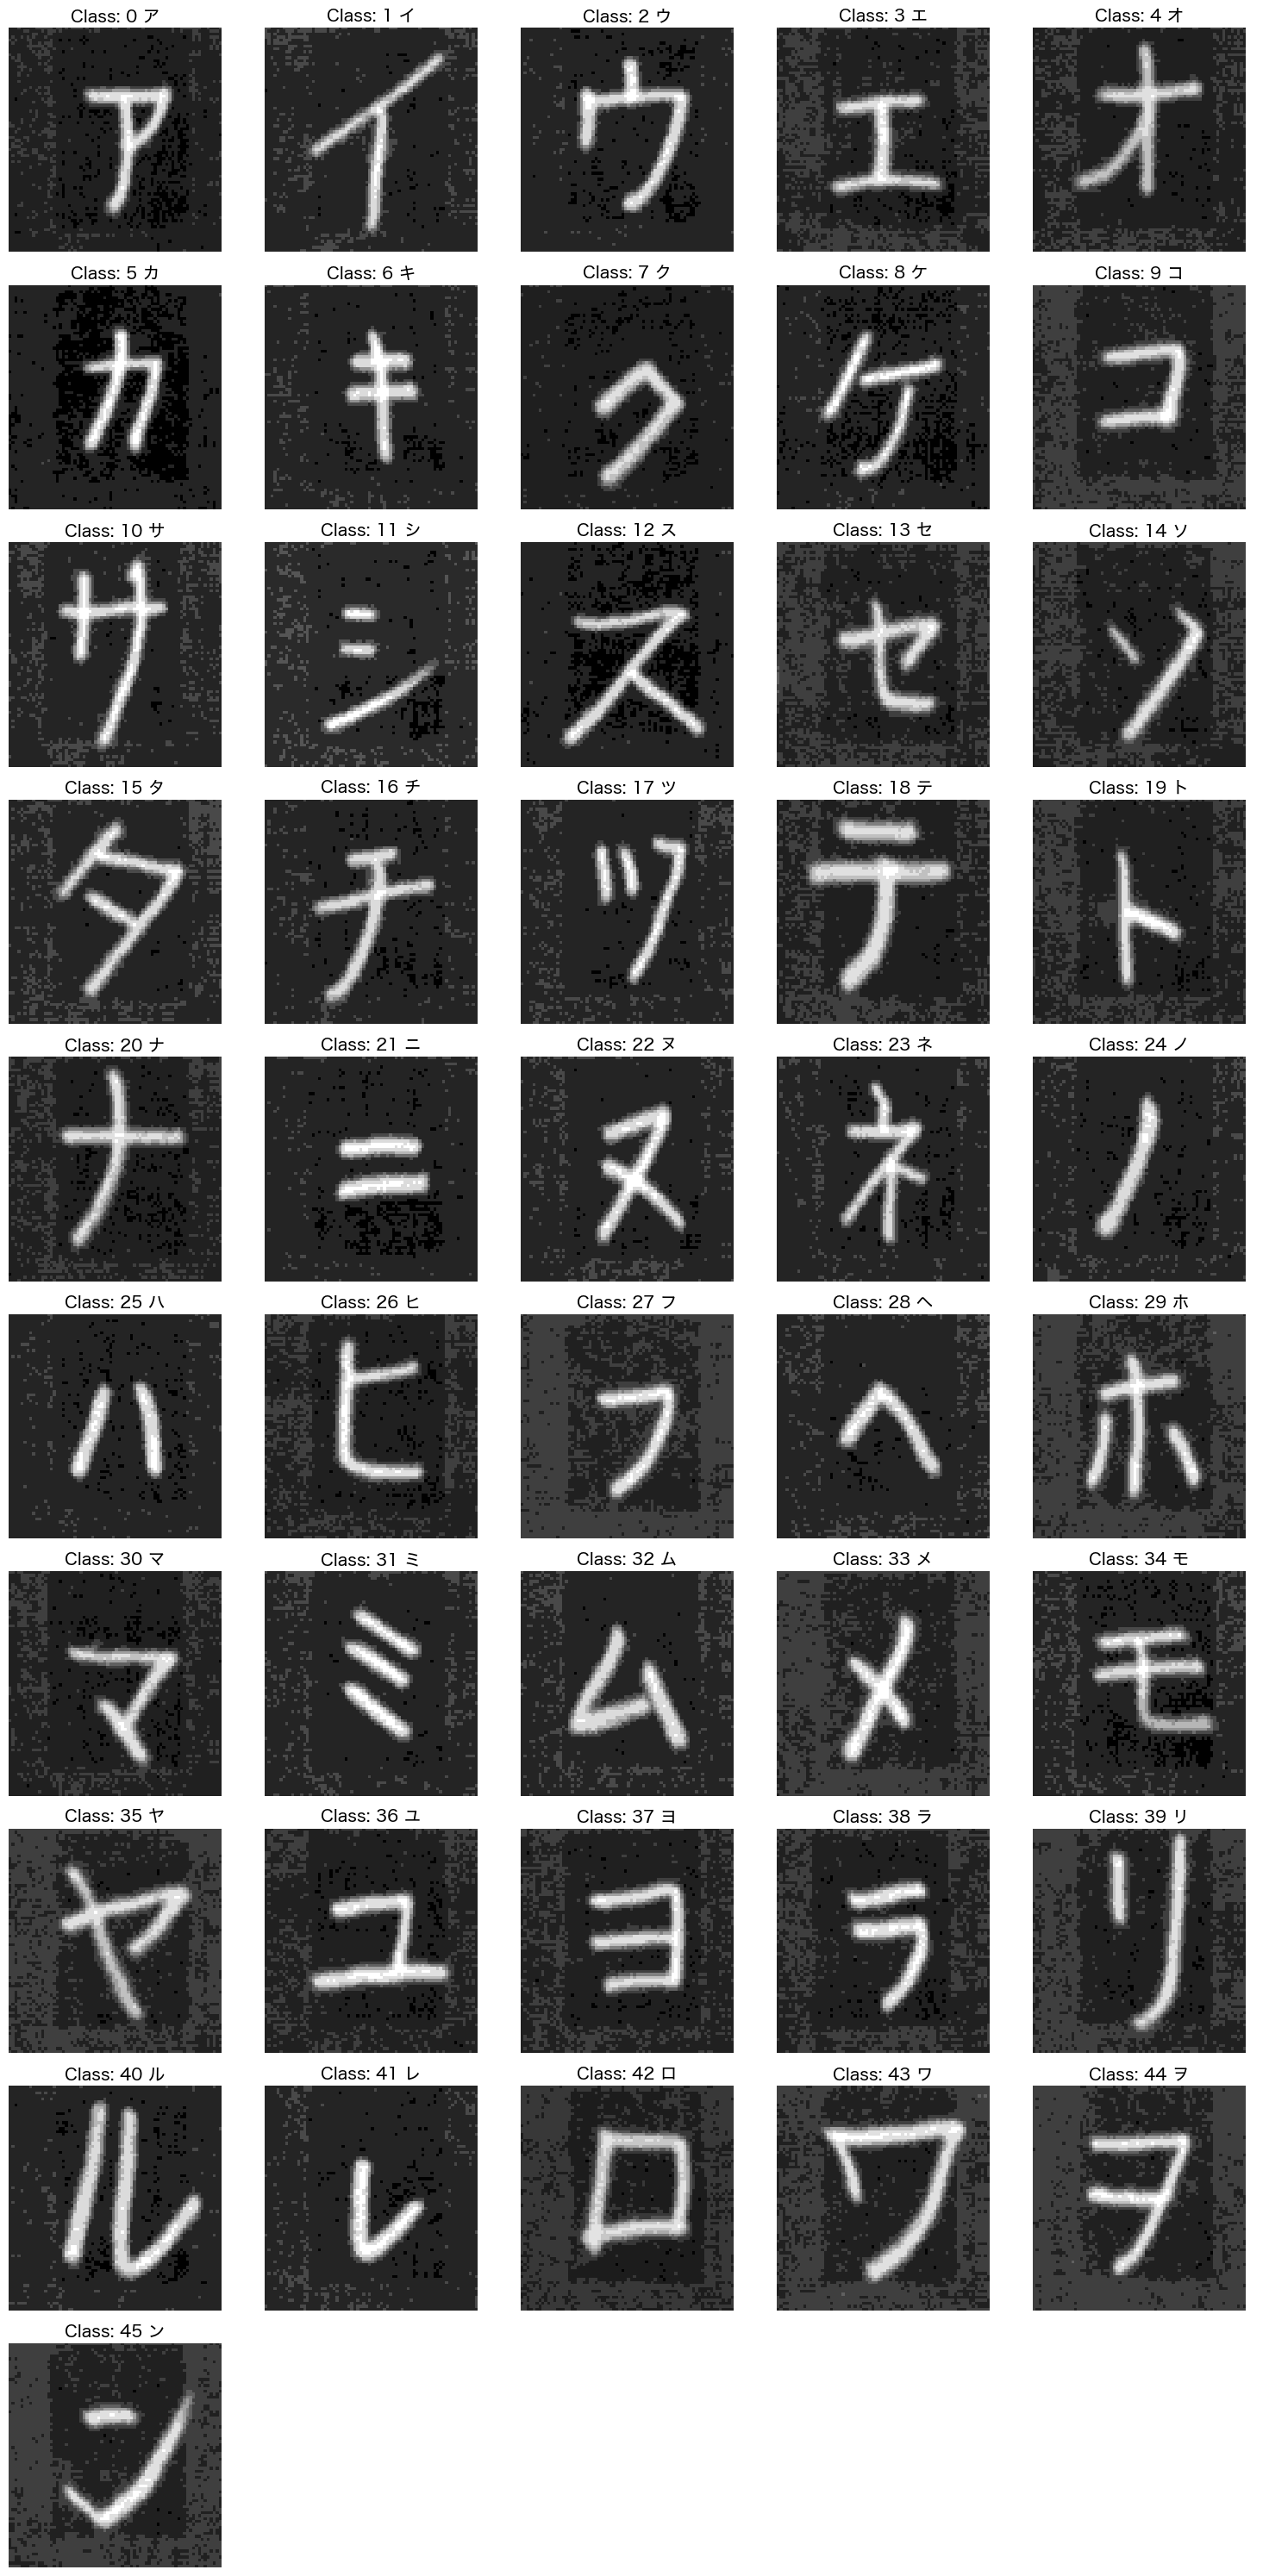

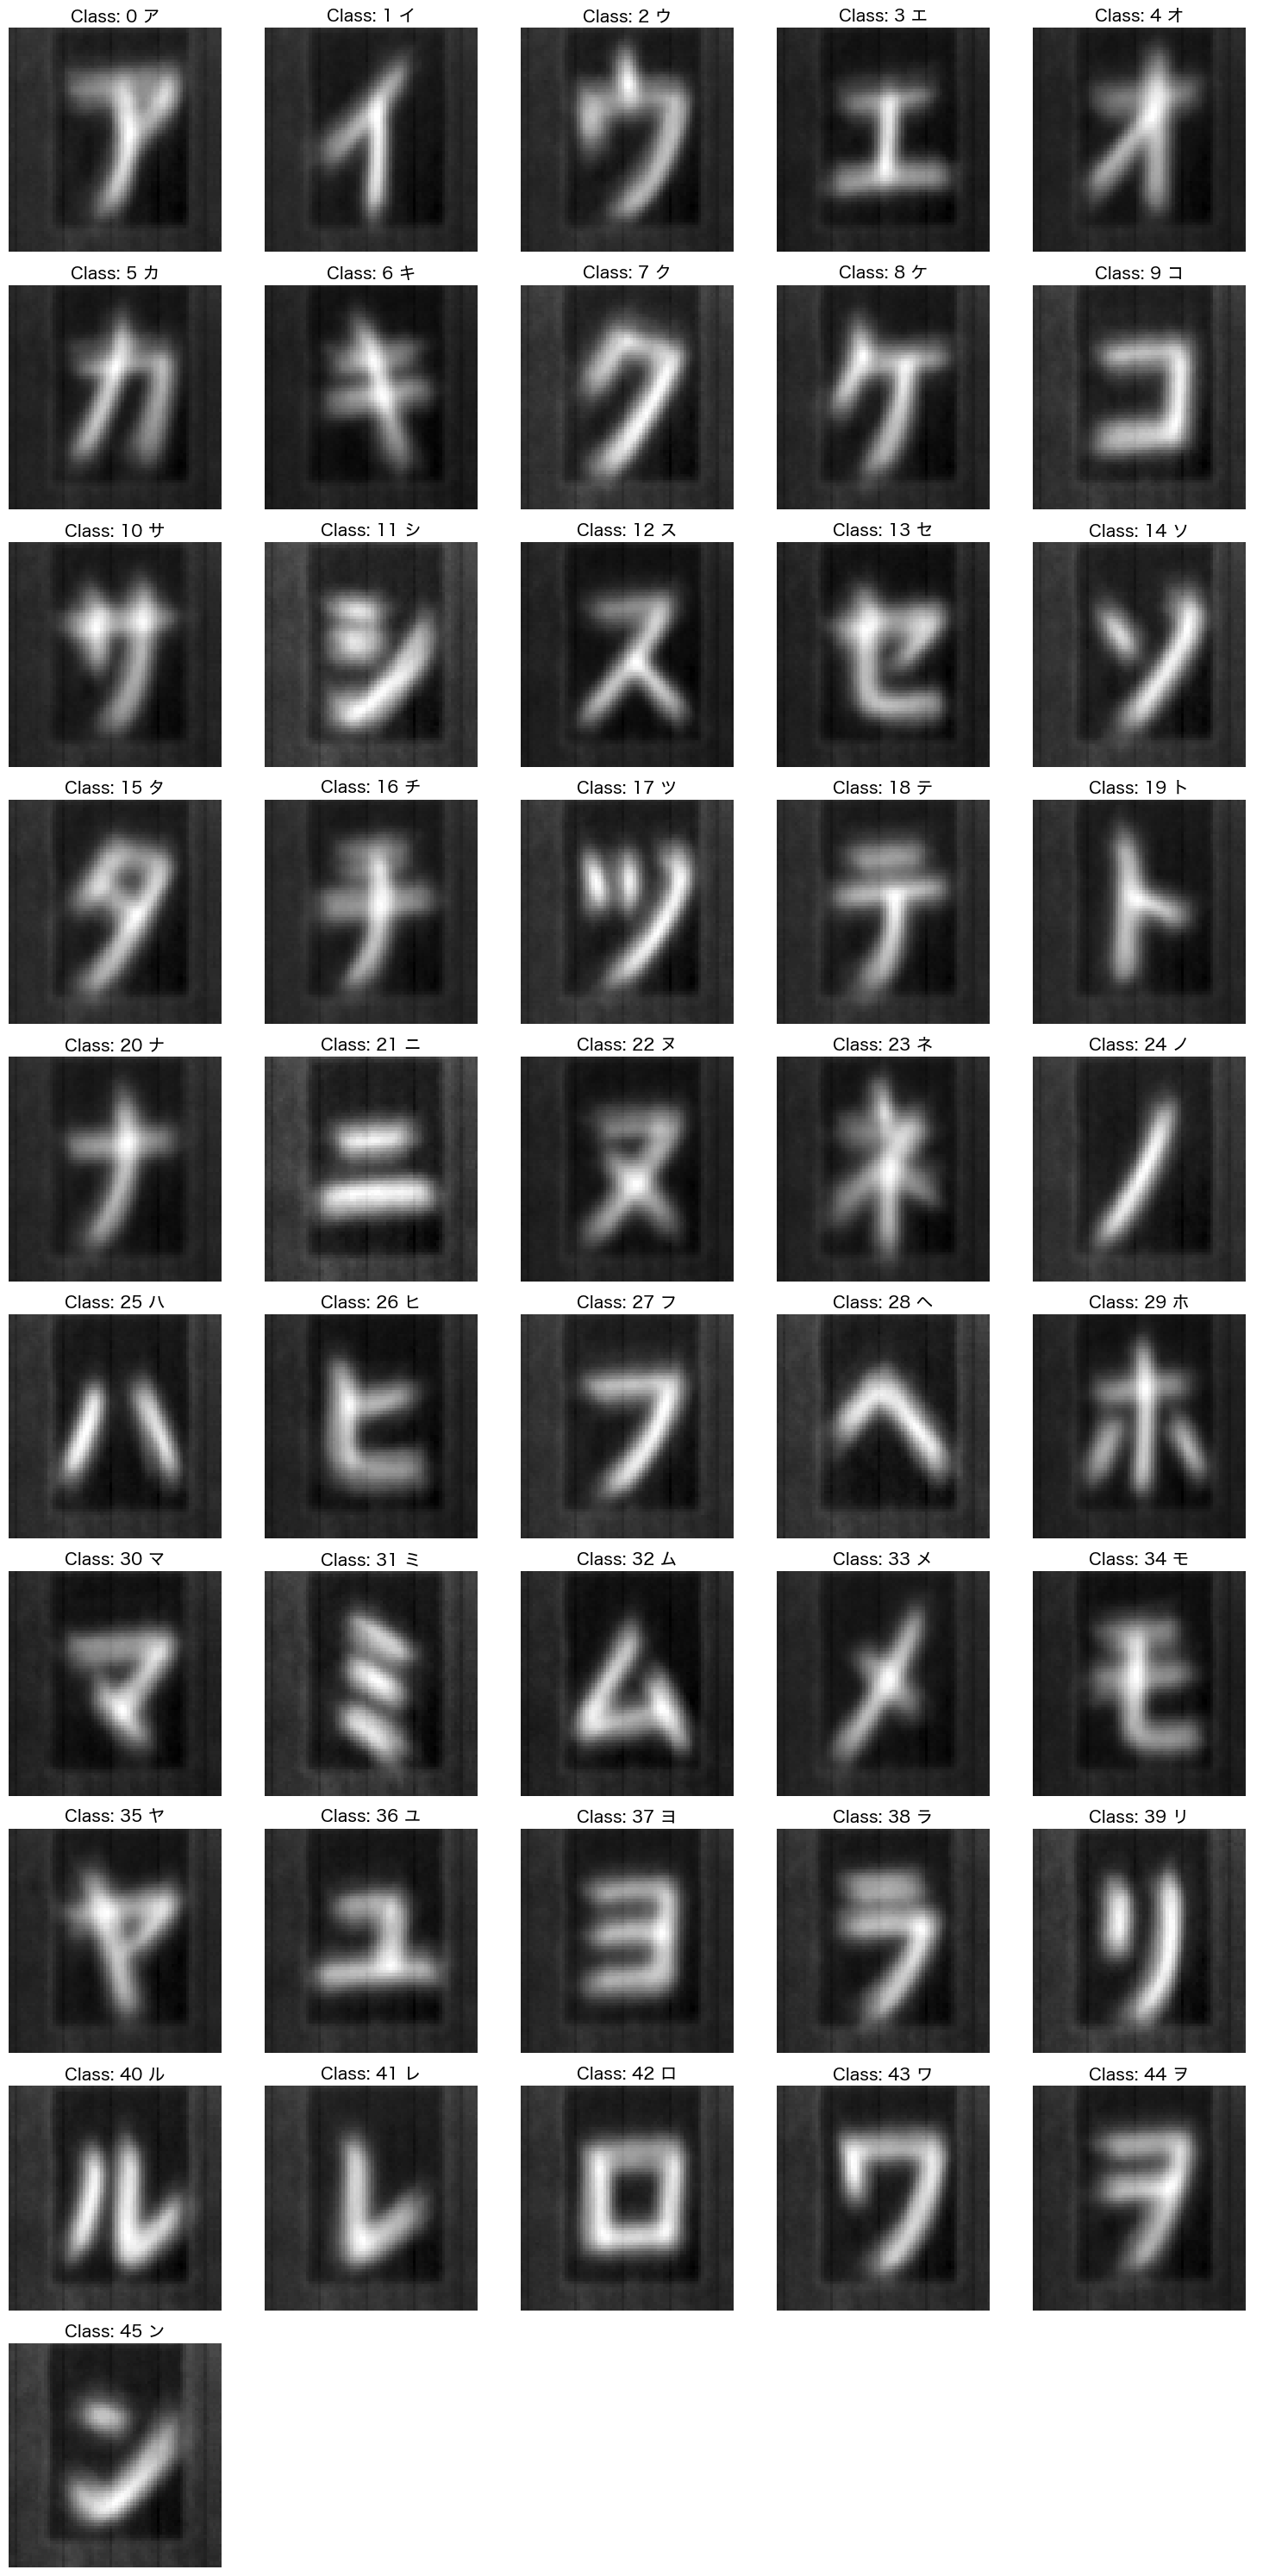

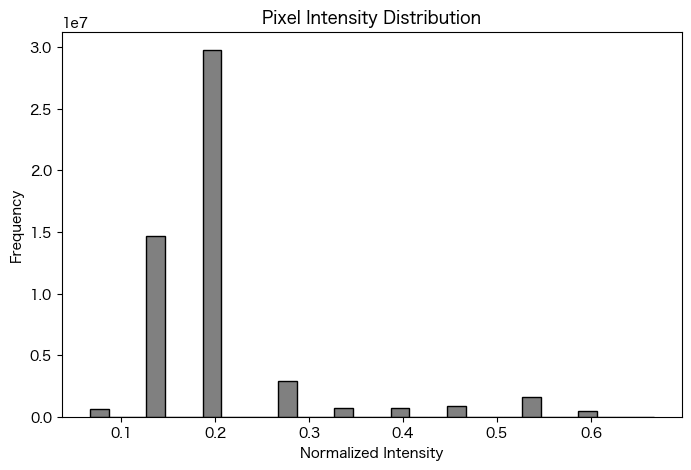

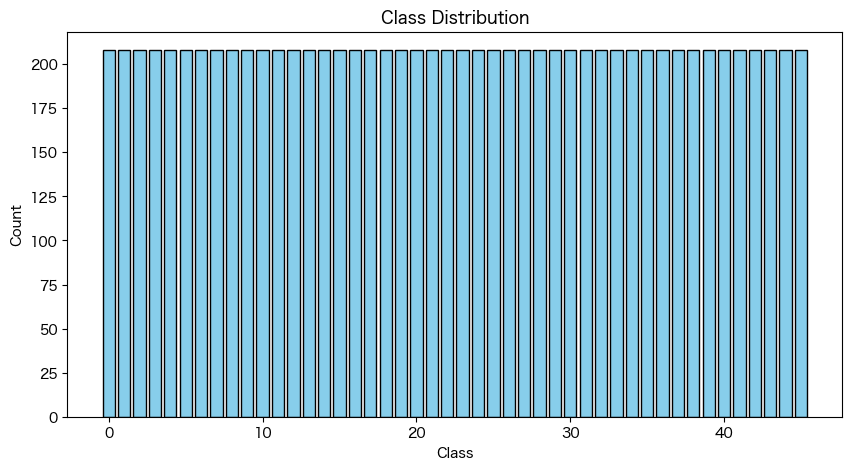

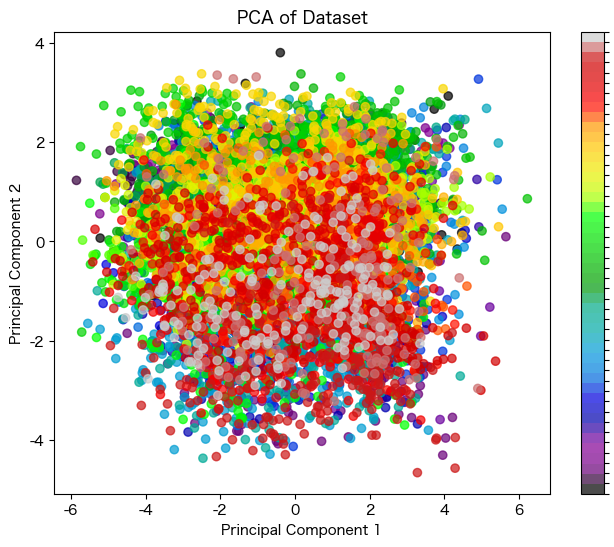

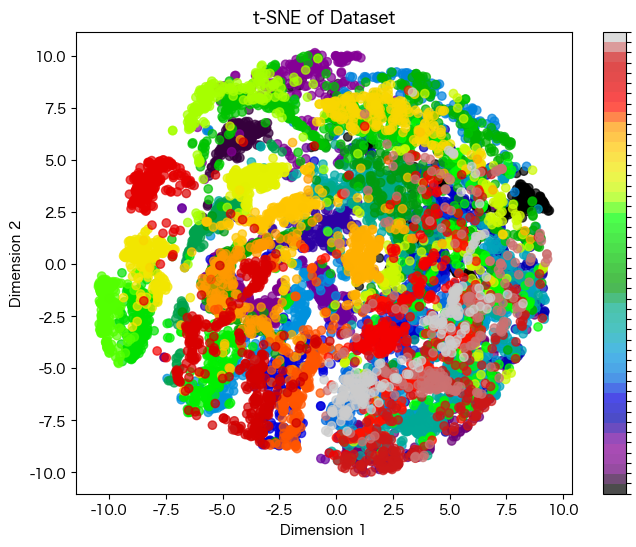

In [6]:
pipeline.eda()

/Users/sid/Desktop/ETL5/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 76, 72, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 76, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 76, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 76, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 38, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,955,534 (11.27 MB)

 Trainable params: 2,954,126 (11.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50

Epoch 1: val_loss improved from inf to 6.91101, saving model to best_model.h5


240/240 - 39s - 162ms/step - accuracy: 0.6721 - loss: 1.3148 - val_accuracy: 0.0230 - val_loss: 6.9110 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 6.91101 to 1.63590, saving model to best_model.h5


240/240 - 38s - 159ms/step - accuracy: 0.9407 - loss: 0.2698 - val_accuracy: 0.4890 - val_loss: 1.6359 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.63590 to 0.08516, saving model to best_model.h5


240/240 - 39s - 163ms/step - accuracy: 0.9713 - loss: 0.1350 - val_accuracy: 0.9801 - val_loss: 0.0852 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 0.08516 to 0.05105, saving model to best_model.h5


240/240 - 39s - 161ms/step - accuracy: 0.9850 - loss: 0.0868 - val_accuracy: 0.9859 - val_loss: 0.0511 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 0.05105 to 0.03234, saving model to best_model.h5


240/240 - 41s - 170ms/step - accuracy: 0.9894 - loss: 0.0596 - val_accuracy: 0.9911 - val_loss: 0.0323 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss improved from 0.03234 to 0.02767, saving model to best_model.h5


240/240 - 37s - 155ms/step - accuracy: 0.9898 - loss: 0.0513 - val_accuracy: 0.9958 - val_loss: 0.0277 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss did not improve from 0.02767
240/240 - 39s - 163ms/step - accuracy: 0.9935 - loss: 0.0347 - val_accuracy: 0.9927 - val_loss: 0.0354 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss improved from 0.02767 to 0.02689, saving model to best_model.h5


240/240 - 38s - 158ms/step - accuracy: 0.9956 - loss: 0.0273 - val_accuracy: 0.9948 - val_loss: 0.0269 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss improved from 0.02689 to 0.02086, saving model to best_model.h5


240/240 - 36s - 149ms/step - accuracy: 0.9940 - loss: 0.0318 - val_accuracy: 0.9969 - val_loss: 0.0209 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss did not improve from 0.02086
240/240 - 36s - 149ms/step - accuracy: 0.9957 - loss: 0.0232 - val_accuracy: 0.9681 - val_loss: 0.0874 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: val_loss did not improve from 0.02086
240/240 - 37s - 152ms/step - accuracy: 0.9926 - loss: 0.0307 - val_accuracy: 0.9911 - val_loss: 0.0394 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_loss did not improve from 0.02086
240/240 - 37s - 154ms/step - accuracy: 0.9918 - loss: 0.0359 - val_accuracy: 0.9958 - val_loss: 0.0231 - learning_rate: 1.0000e-03
Epoch 13/50

Epoch 13: val_loss did not improve from 0.02086
240/240 - 39s - 164ms/step - accuracy: 0.9909 - loss: 0.0332 - val_accuracy: 0.9875 - val_loss: 0.0506 - learning_rate: 1.0000e-03
Epoch 14/50

Epoch 14: val_loss improved from 0.02086 to 0.01778, saving model to best_model.h5


240/240 - 37s - 155ms/step - accuracy: 0.9933 - loss: 0.0282 - val_accuracy: 0.9958 - val_loss: 0.0178 - learning_rate: 1.0000e-03
Epoch 15/50

Epoch 15: val_loss did not improve from 0.01778
240/240 - 38s - 157ms/step - accuracy: 0.9945 - loss: 0.0221 - val_accuracy: 0.9969 - val_loss: 0.0197 - learning_rate: 1.0000e-03
Epoch 16/50

Epoch 16: val_loss did not improve from 0.01778
240/240 - 38s - 160ms/step - accuracy: 0.9944 - loss: 0.0228 - val_accuracy: 0.9943 - val_loss: 0.0254 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 17: val_loss did not improve from 0.01778
240/240 - 38s - 160ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9969 - val_loss: 0.0204 - learning_rate: 1.0000e-03
Epoch 18/50

Epoch 18: val_loss did not improve from 0.01778
240/240 - 37s - 153ms/step - accuracy: 0.9967 - loss: 0.0164 - val_accuracy: 0.9943 - val_loss: 0.0266 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: 

240/240 - 37s - 156ms/step - accuracy: 0.9952 - loss: 0.0171 - val_accuracy: 0.9984 - val_loss: 0.0177 - learning_rate: 5.0000e-04
Epoch 21/50

Epoch 21: val_loss improved from 0.01769 to 0.01723, saving model to best_model.h5


240/240 - 37s - 156ms/step - accuracy: 0.9988 - loss: 0.0059 - val_accuracy: 0.9974 - val_loss: 0.0172 - learning_rate: 5.0000e-04
Epoch 22/50

Epoch 22: val_loss improved from 0.01723 to 0.01492, saving model to best_model.h5


240/240 - 39s - 165ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9984 - val_loss: 0.0149 - learning_rate: 5.0000e-04
Epoch 23/50

Epoch 23: val_loss did not improve from 0.01492
240/240 - 39s - 161ms/step - accuracy: 0.9978 - loss: 0.0055 - val_accuracy: 0.9984 - val_loss: 0.0167 - learning_rate: 5.0000e-04
Epoch 24/50

Epoch 24: val_loss did not improve from 0.01492
240/240 - 37s - 155ms/step - accuracy: 0.9982 - loss: 0.0085 - val_accuracy: 0.9984 - val_loss: 0.0166 - learning_rate: 5.0000e-04
Epoch 25/50

Epoch 25: val_loss did not improve from 0.01492
240/240 - 37s - 155ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9932 - val_loss: 0.0267 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 26: val_loss did not improve from 0.01492
240/240 - 38s - 157ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9963 - val_loss: 0.0215 - learning_rate: 5.0000e-04
Epoch 27/50

Epoch 27: val_loss improved from 0.01492 to 0.01397, saving model to best_model.h5


240/240 - 38s - 156ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9984 - val_loss: 0.0140 - learning_rate: 5.0000e-04
Epoch 28/50

Epoch 28: val_loss did not improve from 0.01397
240/240 - 38s - 157ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9974 - val_loss: 0.0186 - learning_rate: 5.0000e-04
Epoch 29/50

Epoch 29: val_loss did not improve from 0.01397
240/240 - 38s - 157ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9984 - val_loss: 0.0145 - learning_rate: 5.0000e-04
Epoch 30/50

Epoch 30: val_loss did not improve from 0.01397
240/240 - 38s - 159ms/step - accuracy: 0.9980 - loss: 0.0074 - val_accuracy: 0.9974 - val_loss: 0.0184 - learning_rate: 5.0000e-04
Epoch 31/50

Epoch 31: val_loss did not improve from 0.01397
240/240 - 39s - 164ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9979 - val_loss: 0.0173 - learning_rate: 5.0000e-04
Epoch 32/50

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: 

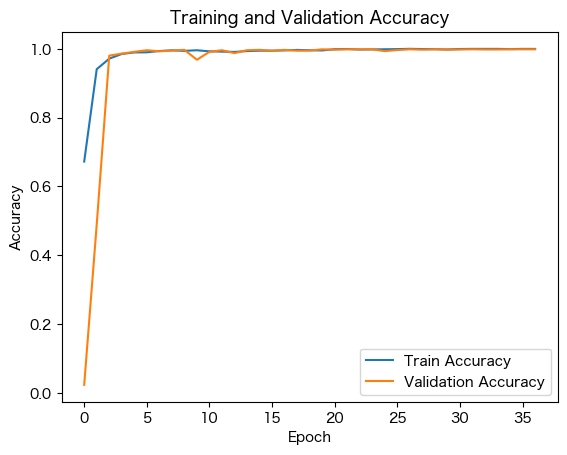

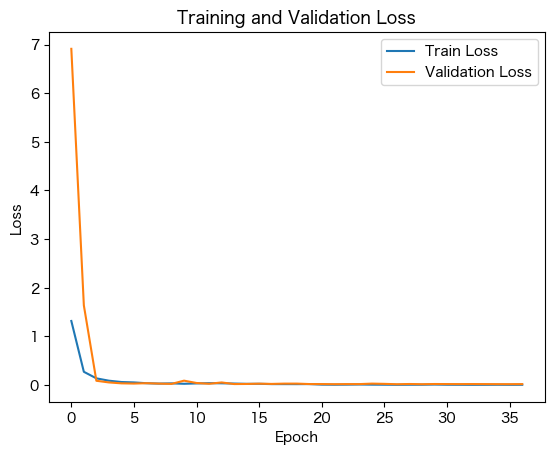

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           ア     1.0000    1.0000    1.0000        43
           イ     1.0000    1.0000    1.0000        44
           ウ     1.0000    1.0000    1.0000        45
           エ     1.0000    1.0000    1.0000        41
           オ     1.0000    1.0000    1.0000        38
           カ     1.0000    1.0000    1.0000        43
           キ     1.0000    1.0000    1.0000        45
           ク     1.0000    1.0000    1.0000        45
           ケ     1.0000    1.0000    1.0000        45
           コ     1.0000    1.0000    1.0000        32
           サ     1.0000    1.0000    1.0000        46
           シ     1.0000    0.9762    0.9880        42
           ス     1.0000    1.0000    1.0000        41
           セ     1.0000    0.9778    0.9888        45
           ソ     1.0000    1.0000    1.0000        52
           タ     1.0000    1.0000    1.0000        41
           チ     1

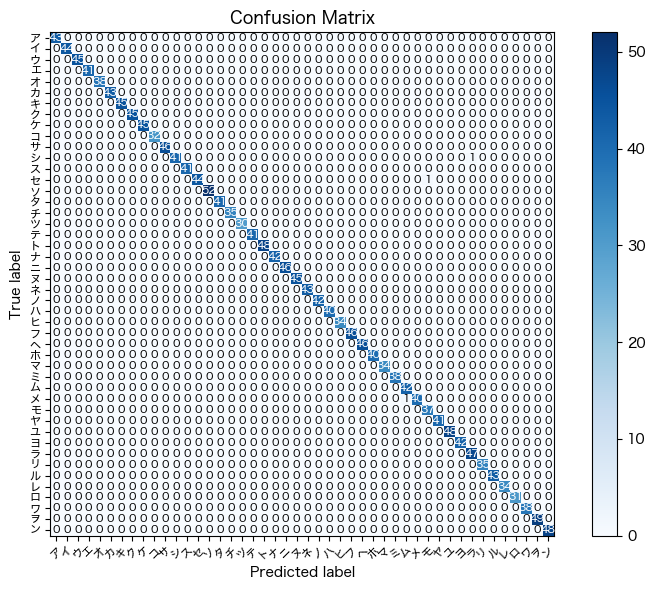

In [7]:
pipeline.build_model()
pipeline.evaluate_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
True label (index): 33 -> メ
Predicted label (index): 33 -> メ
Images in true label mapping: 208
Images in predicted label mapping: 208


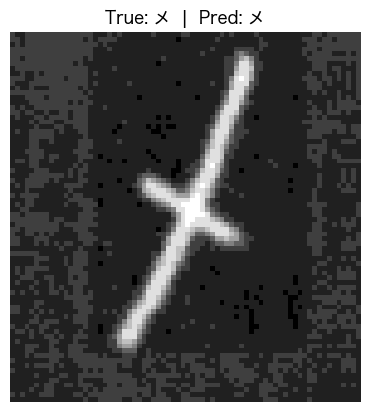

In [19]:
test_single_sample(pipeline.model, pipeline.X_test, pipeline.y_test, pipeline.class_names, pipeline.mapped)

Processing: ./my_imgs/test1.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.032): enhancing contrast.
DEBUG: Original image - mean: 0.204, std: 0.048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


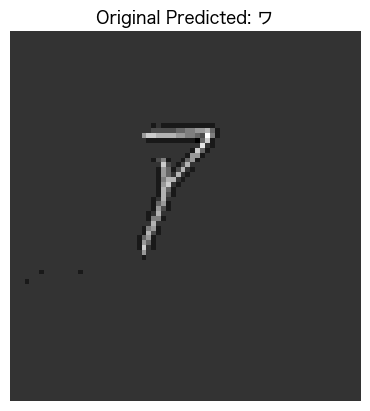

Original prediction probabilities: [[1.0975109e-03 6.2597857e-04 1.9141487e-03 2.0255728e-02 2.0862521e-05
  2.4449435e-04 8.5998872e-05 3.4679615e-04 7.2936754e-04 1.1253439e-04
  9.9388987e-04 8.0388592e-04 2.1947495e-04 7.2323898e-04 1.3094842e-04
  4.4709782e-06 5.1344559e-04 1.9790750e-04 2.8487199e-05 1.0646421e-03
  8.8965887e-04 4.8913839e-03 5.7752004e-05 5.9320150e-06 8.2062540e-04
  3.8851444e-03 2.4791425e-03 4.7803312e-04 8.3210721e-04 4.4116515e-04
  4.6789250e-05 2.0582196e-05 1.4727440e-05 2.4518864e-05 2.5212616e-03
  2.6223811e-04 3.3913630e-03 2.0108728e-05 2.9301096e-04 9.7472215e-04
  2.4124170e-02 3.3070005e-02 1.2112557e-03 8.8896650e-01 9.8663753e-05
  6.5299449e-05]]
Adaptive parameters: 0.25 2 0.15000000000000002
DEBUG: Enhanced image (before resize) - mean: 0.218, std: 0.093
DEBUG: Enhanced image (after resize) - mean: 0.215, std: 0.094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


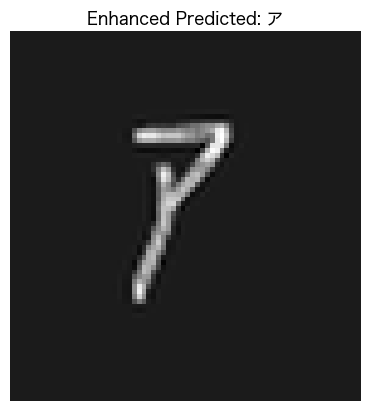

Enhanced prediction probabilities: [[9.5807743e-01 5.1017324e-08 3.4585611e-07 1.0577310e-05 3.9738529e-07
  5.7333726e-03 1.0723321e-09 2.8945475e-08 9.0013195e-08 2.9437732e-07
  1.4979468e-08 2.0610466e-06 4.3892724e-05 7.7385093e-06 8.7598200e-06
  6.8130163e-07 3.2344102e-05 8.0646998e-08 4.2189401e-07 2.2720278e-06
  8.1512017e-06 6.7833352e-09 1.4684391e-02 5.7302479e-08 8.3642844e-06
  1.7103861e-04 6.2857438e-08 3.7250458e-04 8.1581059e-10 1.1966291e-05
  1.2070218e-06 8.7569001e-09 3.8097012e-10 3.4400775e-05 9.6213307e-06
  1.2620114e-06 5.5148321e-06 6.8600602e-06 3.1383991e-06 1.0283197e-08
  1.0748290e-03 5.4412594e-06 1.3531042e-03 1.2320966e-02 6.0062455e-03
  1.1587650e-08]]
Processing: ./my_imgs/test2.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.033): enhancing contrast.
DEBUG: Original image - mean: 0.129, std: 0.071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


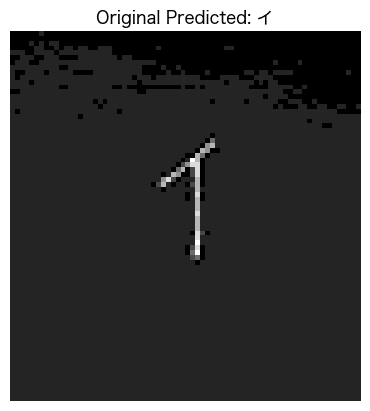

Original prediction probabilities: [[3.8243108e-04 9.4765007e-01 6.4997744e-07 4.1445727e-03 2.0711611e-04
  1.9474548e-07 9.4734271e-05 3.0227768e-05 1.1706257e-04 1.5961837e-02
  3.2386606e-04 2.1703470e-06 3.6431252e-04 3.2386713e-06 1.8650701e-04
  5.9588881e-05 1.3163337e-05 1.4483565e-05 2.3205286e-04 3.0728658e-03
  4.8474281e-04 4.0615769e-03 5.7884308e-06 2.4676563e-06 2.6325418e-03
  3.7363975e-04 4.3307497e-05 8.9895053e-05 1.0584945e-02 2.5541835e-06
  2.2486497e-03 2.2247371e-04 1.2907879e-04 1.2593402e-03 1.1787235e-05
  6.3561596e-04 2.4155949e-04 7.0501951e-06 1.1640214e-05 7.0529460e-04
  1.1022646e-05 3.1464717e-03 3.1565247e-05 5.8979578e-05 1.1453794e-05
  1.2538600e-04]]
Adaptive parameters: 0.25 2 0.15000000000000002
DEBUG: Enhanced image (before resize) - mean: 0.165, std: 0.117
DEBUG: Enhanced image (after resize) - mean: 0.164, std: 0.117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


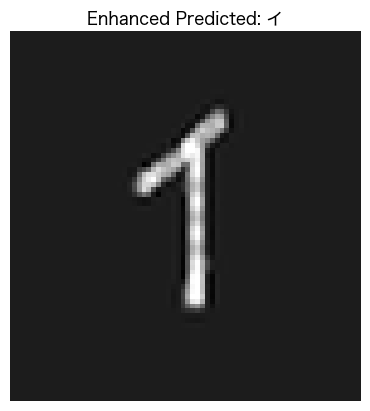

Enhanced prediction probabilities: [[5.4736790e-07 9.9997377e-01 3.5648301e-12 4.0647828e-06 8.0807132e-07
  8.6427906e-11 1.8846841e-07 1.6940996e-08 3.9201413e-07 2.2329243e-09
  2.2367361e-08 7.4448303e-10 1.6901684e-08 2.7053628e-11 1.0861065e-09
  2.2753511e-06 1.5624984e-05 5.4729839e-11 1.6157698e-07 3.3825831e-08
  4.4930150e-11 2.9537392e-10 2.0604876e-08 1.0865044e-09 1.7386880e-09
  1.6377814e-10 1.4570517e-09 3.9071281e-12 2.6215730e-07 3.5185039e-08
  4.7611032e-10 1.6999085e-09 1.5470629e-07 3.6506282e-08 1.1044635e-08
  6.6101973e-07 7.4181941e-07 4.1574513e-08 6.6558337e-10 6.1260561e-09
  1.2031171e-08 6.8010714e-08 7.9605105e-09 5.4442326e-09 4.3781365e-09
  3.2840959e-11]]
Processing: ./my_imgs/test3.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.045): enhancing contrast.
DEBUG: Original image - mean: 0.210, std: 0.076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


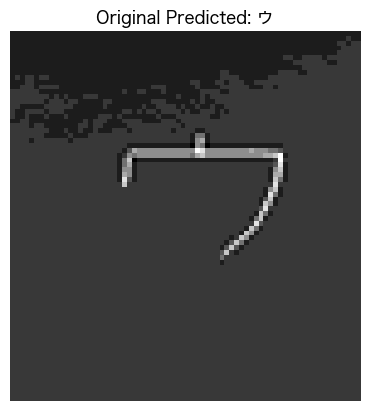

Original prediction probabilities: [[4.04002858e-05 2.79515052e-06 6.74341619e-01 1.91752421e-04
  4.18921882e-05 6.28813577e-04 7.59064496e-05 5.52949775e-03
  9.32813491e-05 2.90512631e-04 3.07270791e-03 3.44438187e-04
  1.08347613e-05 1.80375762e-02 4.83071111e-04 8.48883719e-05
  5.13519308e-06 1.88814163e-01 3.02312969e-07 1.78897302e-04
  7.71556457e-04 3.18972481e-04 7.55240762e-06 9.15424898e-05
  2.39030051e-05 1.56291382e-04 3.80756363e-04 4.97594767e-04
  1.50253225e-04 3.54030781e-05 2.68341624e-04 3.36782396e-05
  2.90587877e-06 1.15064622e-05 2.30741833e-04 1.36675593e-03
  3.66979308e-04 1.02204581e-06 2.22302042e-04 3.93848568e-05
  1.23860955e-03 4.95016830e-05 7.25411810e-04 1.00393705e-01
  7.38638937e-06 3.39530321e-04]]
Adaptive parameters: 0.2 2 0.1
DEBUG: Enhanced image (before resize) - mean: 0.184, std: 0.135
DEBUG: Enhanced image (after resize) - mean: 0.184, std: 0.135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


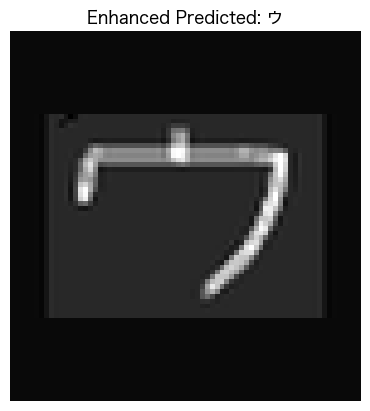

Enhanced prediction probabilities: [[5.85470218e-07 5.70859887e-11 9.92882013e-01 3.31780683e-08
  6.07979223e-09 2.97998125e-03 8.98998422e-08 7.63116346e-04
  3.61110779e-07 7.91173250e-07 5.15583395e-07 1.50503865e-06
  1.11248667e-07 2.08068150e-03 4.70770630e-07 1.22401325e-05
  4.81633265e-07 4.42446617e-04 4.68929409e-11 4.41252190e-09
  3.16841374e-06 2.24986554e-08 8.18456769e-08 3.99607052e-06
  1.99015915e-08 9.11095199e-09 4.14967580e-08 6.25287939e-04
  2.69599610e-07 2.94506481e-08 5.69315944e-07 7.16008453e-09
  2.02215134e-08 5.34816147e-09 8.13633321e-08 2.32940838e-05
  9.49013793e-06 6.13788709e-09 1.64449136e-06 6.56709265e-09
  1.27276326e-06 2.09366409e-08 2.15634429e-07 9.84193612e-05
  1.21299117e-05 5.44409377e-05]]
Processing: ./my_imgs/test4.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.045): enhancing contrast.
DEBUG: Original image - mean: 0.172, std: 0.062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


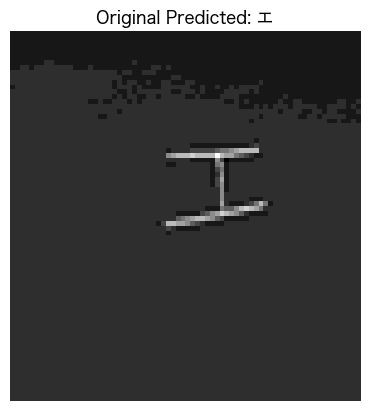

Original prediction probabilities: [[7.4957381e-05 1.3768639e-04 2.7190384e-07 7.9934454e-01 6.9148082e-05
  4.2505217e-08 5.8735273e-04 1.6611998e-06 4.3138451e-04 4.2145519e-05
  4.1901390e-06 1.2705888e-06 1.3119534e-04 5.7672792e-06 9.3569923e-07
  3.9332954e-06 1.6815536e-02 1.5245552e-06 1.7649785e-04 2.1106107e-04
  5.2482693e-04 1.7311636e-01 1.7885028e-05 5.7478528e-06 3.8117353e-06
  2.2205495e-06 1.1424699e-03 2.8996301e-06 1.7185263e-04 2.8142842e-05
  7.0312672e-05 2.4238168e-03 3.3765551e-05 6.8078829e-05 4.0299594e-03
  3.8895534e-05 9.4112977e-05 2.9179375e-05 2.1311664e-06 2.1305131e-07
  3.1657287e-06 3.4409568e-06 6.5708182e-06 6.6035750e-07 3.7465604e-08
  1.3826616e-04]]
Adaptive parameters: 0.25 2 0.15000000000000002
DEBUG: Enhanced image (before resize) - mean: 0.215, std: 0.123
DEBUG: Enhanced image (after resize) - mean: 0.214, std: 0.124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


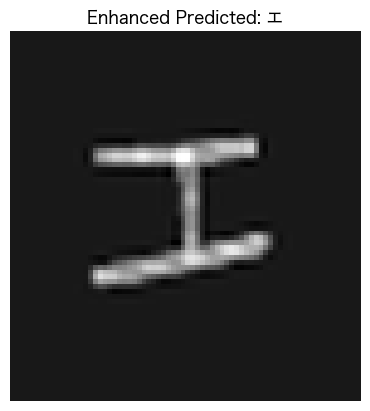

Enhanced prediction probabilities: [[4.9258301e-08 5.0033496e-13 2.3660008e-12 9.9996674e-01 6.4203372e-09
  1.3292683e-12 6.0421235e-10 3.4351165e-13 8.2288114e-09 1.3665569e-09
  3.9872348e-11 4.4228898e-10 1.9665239e-10 4.2884066e-10 1.0360884e-12
  3.8081399e-10 8.8748141e-07 2.3911626e-11 3.3159154e-07 1.2869839e-11
  7.6144385e-10 5.8853235e-08 1.1377401e-07 1.0006098e-11 6.3072195e-15
  1.3211048e-11 1.1933248e-08 3.1284569e-12 2.1041450e-11 1.2062169e-09
  4.0369444e-11 2.1329098e-08 4.2276746e-10 2.9388922e-11 2.2158281e-05
  2.0830142e-10 4.6987807e-08 9.6013136e-06 1.0233740e-11 3.1458451e-12
  1.4083879e-09 3.9065309e-10 8.7429207e-08 5.7356991e-10 2.4944753e-12
  2.1472758e-10]]
Processing: ./my_imgs/test5.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.046): enhancing contrast.
DEBUG: Original image - mean: 0.209, std: 0.077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


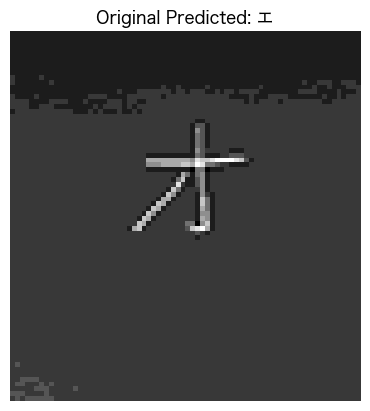

Original prediction probabilities: [[7.3892334e-06 7.2504365e-05 2.4855808e-08 9.8319918e-01 7.2143776e-03
  6.3512863e-07 1.4368377e-03 3.3547059e-07 1.0193901e-03 1.5401139e-06
  9.0864522e-04 5.3267206e-07 7.8800786e-06 3.3003455e-06 2.1520389e-08
  1.8419835e-04 3.7827124e-03 5.9101749e-06 2.3482244e-05 2.1012472e-06
  9.1122201e-05 6.9886475e-05 6.8904112e-05 2.6301294e-07 8.1519387e-09
  1.1576788e-06 4.6561090e-05 9.4153263e-09 5.7640871e-05 4.2432497e-04
  5.9040201e-07 1.9883113e-04 8.5236152e-06 9.8520679e-05 8.2050392e-04
  2.1999209e-05 2.3386065e-06 1.9799967e-04 1.7064082e-08 1.5432742e-07
  3.0181645e-06 1.6307361e-07 1.5039058e-05 9.3236758e-07 1.8292801e-07
  3.3684492e-07]]
Adaptive parameters: 0.25 2 0.15000000000000002
DEBUG: Enhanced image (before resize) - mean: 0.195, std: 0.155
DEBUG: Enhanced image (after resize) - mean: 0.195, std: 0.156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


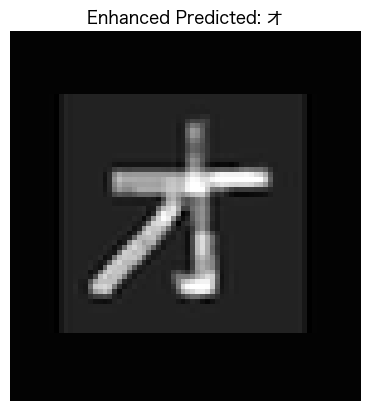

Enhanced prediction probabilities: [[8.02085342e-05 8.12803307e-07 4.76046633e-11 2.19105914e-01
  7.54260242e-01 1.27530730e-05 3.48634131e-07 5.82268900e-10
  2.84248854e-05 2.45792137e-07 1.50781343e-04 6.14366957e-09
  1.49444384e-06 1.96432975e-05 7.32428340e-10 3.54464777e-04
  7.00855395e-04 6.02511889e-08 7.82423467e-06 1.13027765e-09
  4.99031876e-06 2.22213759e-09 8.96768551e-03 3.00220154e-06
  8.53208389e-12 6.33085193e-08 1.59459930e-07 8.74048681e-11
  4.38165337e-10 8.97871610e-03 8.11078760e-09 1.83751024e-06
  3.64225230e-06 9.44393338e-04 2.37132510e-04 4.94594985e-07
  4.48426761e-07 5.78163005e-03 3.33255624e-12 7.21035898e-10
  1.29540776e-05 9.50426848e-10 3.38504702e-04 1.07331222e-09
  1.05959955e-07 2.48602872e-09]]
Processing: ./my_imgs/test6.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.043): enhancing contrast.
DEBUG: Original image - mean: 0.118, std: 0.080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


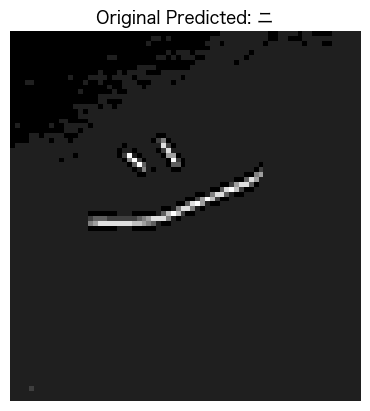

Original prediction probabilities: [[1.6636972e-09 5.8686578e-06 8.3051476e-04 2.4208850e-05 4.4378826e-06
  5.5808201e-08 3.6226544e-03 3.8373451e-05 3.6512185e-05 9.0627094e-05
  8.4517325e-07 1.7965836e-02 1.6146654e-05 8.4754029e-06 1.8448666e-06
  2.4129131e-08 5.7139204e-07 3.5865340e-04 2.5719914e-06 4.1623352e-04
  2.8109350e-04 9.6340024e-01 3.4915137e-09 4.3475644e-05 1.6934794e-04
  1.6661243e-06 1.0677729e-02 6.8528738e-07 2.0809146e-04 2.2680356e-07
  8.1856092e-07 3.2574582e-05 2.4296985e-04 1.7288805e-06 4.3778570e-07
  6.8372268e-05 7.5487694e-04 4.8558945e-07 7.0721235e-06 6.0172788e-06
  3.1903521e-05 1.3653949e-04 7.9388776e-08 9.8846167e-06 4.2878767e-08
  4.9919379e-04]]
Adaptive parameters: 0.2 2 0.1
DEBUG: Enhanced image (before resize) - mean: 0.147, std: 0.123
DEBUG: Enhanced image (after resize) - mean: 0.145, std: 0.123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


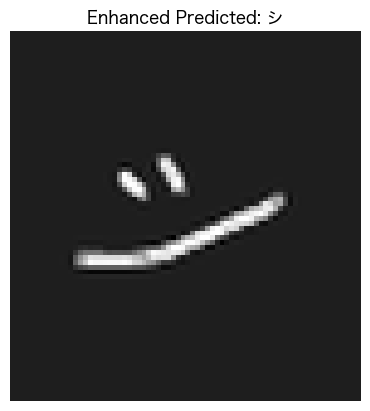

Enhanced prediction probabilities: [[2.6996879e-12 6.2460779e-12 6.5330722e-05 2.3516623e-06 2.0575226e-09
  2.4203056e-10 3.5177934e-05 1.9490825e-09 3.1672609e-08 8.4252576e-08
  8.7649052e-09 9.8617387e-01 3.9294599e-09 2.3094599e-05 4.7499604e-09
  1.2232482e-09 2.3270936e-09 1.0063861e-02 4.1846815e-10 1.7710483e-09
  1.3767660e-08 1.3500934e-04 1.4388699e-08 3.4981335e-06 5.5768062e-10
  1.8220331e-09 2.6215683e-04 1.0833166e-12 7.0814572e-09 2.6530016e-08
  1.1365200e-11 2.6525490e-06 5.8976235e-04 8.5527585e-09 2.6333185e-09
  3.9126738e-07 2.4377410e-03 1.4140217e-05 3.3516634e-11 1.1433139e-08
  1.8783701e-04 7.3135334e-07 6.4374062e-09 6.8193124e-08 7.2115464e-13
  2.0573020e-06]]


In [21]:


my_imgs_filepath = './my_imgs'
filepaths = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
for filename in filepaths:
    full_path = f"{my_imgs_filepath}/{filename}"
    print("Processing:", full_path)
    evaluate_single_image(pipeline.model, full_path, pipeline.class_names)

In [ ]:
# confirm my mapping works
# display_class_samples(pipeline.mapped, katakana_chars_modern, pipeline.mapping)